In [8]:
#
# NOTE: This workflow is for predicting weather, using convolutional LSTM
#       architechture. The training data is a set of reanalysis data in the
#       past for one specific domain that are regular gridded at regular
#       intervals in the NETCDF format. This system consists of three stages
#       as given below:
#
#       - Stage 1: reading NETCDF input and generating training dataset with a
#                  given image sizes, number of frames, number of sample, and
#                  number of channels, which are saved by pickle;
#       - Stage 2: import the saved pickle data and split this data into a lag
#                  pair (X,Y), with the lag time (forecast lead time) prescribed
#                  in advance). This stage will then build a convolutional LSTM
#                  model with a given training/validation ratio, and then save
#                  the train model under the name "nwp_model_hhh", where hhh is
#                  forecast lead time. It also saves the history of training
#                  in the form of pickle format for later analysis.
#       - Stage 3: testing the performance of the model by importing the best
#                  trained model from Stage 2, and make a list of prediction
#                  to be validated with the test data. Note that this stage is
#                  best to run in the Jupyter notebook mode so the prediction
#                  can be visuallly checked.
#
# INPUT: This Stage 3 script requires the best trained model from Stage 2, and an 
#        input dataset in the pickle that are produced from Stage 1 for testing the 
#        model performance  Note again that the input data are given in each year 
#        separately, because Stage 1 takes a long time ro process and so it is
#        designed to process year by year only.
#
# OUTPUT: A graphic prediction at different forecast leadtime from a test sample 
#         data.
#
#         Remark: this script is currently designed to run in Jupyter notebook mode
#         only due to the requirement of visualization examination. If it is used as
#         prediction model, then it should only be saved and run in the job submission 
#         mode instead of Jupyter notebook, as it may require a lot of time and memory
#         that will be crashed easily if running with Jupyter.
#
# HIST: - 12, Oct 23: Created by CK
#       - 10, Nov 23: revised for a better workflow for future upgrades
#                     and sharing
#
# AUTH: Chanh Kieu (Indiana University, Bloomington. Email: ckieu@iu.edu)
#======================================================================================
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import time
from tensorflow.keras.callbacks import TensorBoard
import libtcg_utils as tcg_utils

In [9]:
#
# function to read in data from pickle. Note that we have to flip the frame here
# as the data saved in pickle is arraged as (t,t-1,t-2,...t-n). We need to have
# here as an output the order (t-n,...,t-2,t-1,t)
#
def readindata(year_list):
    for i,yyyy in enumerate(year_list):
        #print("Openning year data: ",yyyy)
        pickle_in = open("nwp_convlstm_"+yyyy+".pickle","rb")
        X = pickle.load(pickle_in)
        nc = X.shape[-1]
        nf = X.shape[1]
        nx = X.shape[3]
        ny = X.shape[2]
        nb = X.shape[0]
        #print('--->Input shape of the X features data: ',X.shape)
        #print('--->Number of input channel extracted from X is: ',nc)
        #print('--->Number of input frames extracted from X is: ',nf)
        if i == 0:
            #datain = np.zeros((nb,nf,ny,nx,nc))
            datain = X
        else:
            datain = np.concatenate((datain,X),axis=0)
        reversed_datain = np.flip(datain,axis=1)    
        print("Year and its input data shape:",yyyy,datain.shape)
    return reversed_datain
#
# Split into train and validation sets using indexing to optimize memory, using
# 90% for training and 10% for validation
#
def data_split_normalize(dataset,ratio=0.8):
    indexes = np.arange(dataset.shape[0])
    np.random.shuffle(indexes)
    train_index = indexes[: int(ratio*dataset.shape[0])]
    val_index = indexes[int(ratio*dataset.shape[0]):]
    train_dataset = dataset[train_index]
    val_dataset = dataset[val_index]

    train_dataset = tcg_utils.normalize_frame_data(train_dataset)
    val_dataset = tcg_utils.normalize_frame_data(val_dataset)
    #print("Check normalized max for channel 1",tcg_utils.maxval_framedata(train_dataset,1,1))
    #print("Check normalized max for channel 5",tcg_utils.maxval_framedata(train_dataset,5,1))
    #print("Check normalized max for channel 9",tcg_utils.maxval_framedata(train_dataset,9,1))
    return train_dataset,val_dataset
#
# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n. Note that this function
# will be important as it defines the lead times. Shifting 1 means 1-lead time
# ahead. Likewise, shifting k means k-lead time ahead.
#
def create_shifted_frames(data,shift=1):
    print("Input for the shift function is: ",data.shape)
    x = data[:, 0:(data.shape[1]-shift), :, :, :]
    y = data[:, shift:data.shape[1], :, :, :]
    print("After shifting produces:", x.shape,y.shape)
    return x, y
#
# function to quick check visualization
#
def visulization(model,val_dataset,channel=1):
    example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]
    print("Example sample is: ",example.shape,np.random.choice(range(len(val_dataset)), size=1)[0])
    #
    # pick the first 7 frame as input and make prediction for the last 2 frames
    #
    frames = example[:7, ...]
    original_frames = example[7:, ...]
    print("Input frames and original frames shapes are: ",frames.shape,original_frames.shape)
    #
    # Predict a new set of 2 frames.
    for _ in range(2):
    # Extract the model's prediction and post-process it.
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        print("Output from prediction: ",new_prediction.shape,_)
        new_prediction = np.squeeze(new_prediction, axis=0)
        print("After squeezing from prediction: ",new_prediction.shape,_)
        # take the last one from new_prediction and concatenate to the input
        # frame to serve as a new input frame. Note that y is lagged by 1 relative
        # to x, i.e., x input from [0-9] corresponds to y output [1-10]. So the
        # new_prediction will be [1-10] similar to y. Taking the last slice [-1,...]
        # would mean the prediction at time t = 10, given input x frames from 0-9.
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
        print("After expanding from prediction: ",predicted_frame.shape,_)
        # Extend the set of prediction frames.
        frames = np.concatenate((frames, predicted_frame), axis=0)
    #
    # plot the original frame to compare with the predicted frame
    #
    fig, axes = plt.subplots(2,2, figsize=(10, 4))
    for idx, ax in enumerate(axes[0]):
        cs=ax.contourf(original_frames[idx,:,:,channel],vmin=0.8,vmax=1.0,cmap='coolwarm')
        ax.set_title(f"Original frame {idx + 1}")
        ax.axis("off")        
        fig.colorbar(cs)

    new_frames = frames[7:,...]
    for idx, ax in enumerate(axes[1]):
        cs=ax.contourf(new_frames[idx,:,:,channel],cmap='coolwarm')
        ax.set_title(f"Predicted frame {idx + 1}")
        ax.axis("off")
        fig.colorbar(cs)

    plt.show()
#
# function to plot the history of the trained model
#
def plot_history():
    with open('./nwp_convlstm_history.pickle', "rb") as fhist:
        history = pickle.load(fhist)
    #print(history)
    plt.plot(history['root_mean_squared_error'], label='Training rmse')
    plt.plot(history['val_root_mean_squared_error'], label = 'Validation rmse')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    #plt.ylim([0.5, 1])
    plt.legend(loc='upper right')
    plt.show()

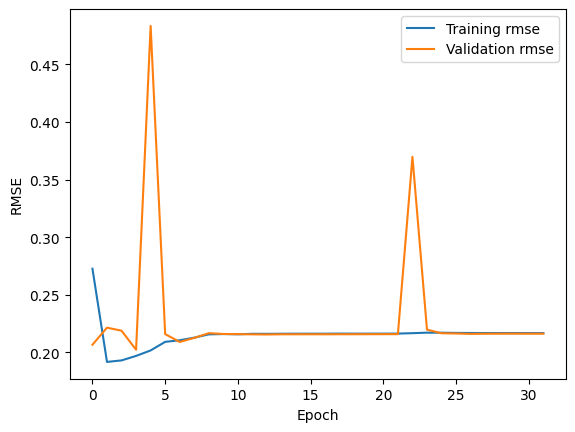

Year and its input data shape: 2021 (196, 9, 41, 161, 12)
Finish normalization...
Finish normalization...
train and val dataset shapes are: (98, 9, 41, 161, 12) (98, 9, 41, 161, 12)
Input for the shift function is:  (98, 9, 41, 161, 12)
After shifting produces: (98, 8, 41, 161, 12) (98, 8, 41, 161, 12)
Input for the shift function is:  (98, 9, 41, 161, 12)
After shifting produces: (98, 8, 41, 161, 12) (98, 8, 41, 161, 12)
Training dataset (x,y) shape: (98, 8, 41, 161, 12), (98, 8, 41, 161, 12)
Validation dataset (x,y) Shape: (98, 8, 41, 161, 12), (98, 8, 41, 161, 12)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 41, 161, 1  0         
                             2)]                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 41, 161, 16  16192     
               

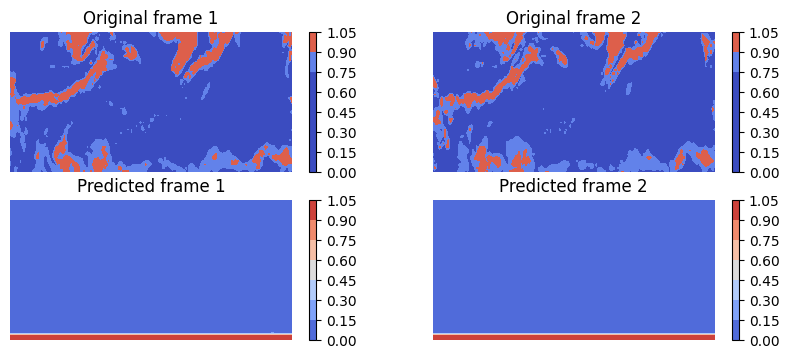

In [12]:
#
# main program
#
if __name__ == '__main__':
    #
    # plot history of the model training
    #
    history_plot = "yes"
    if history_plot == "yes":
        plot_history()
    #
    # read in data output from Part 1 and normalize it
    #
    year_list = ["2021"]
    datain = readindata(year_list)
    #
    # normalize and split data into train/validation
    #
    train_dataset,val_dataset = data_split_normalize(datain,ratio=0.5)
    print("train and val dataset shapes are:",train_dataset.shape,val_dataset.shape)
    #
    # Apply the processing function to the datasets.
    #
    x_train, y_train = create_shifted_frames(train_dataset,1)
    x_val, y_val = create_shifted_frames(val_dataset,1)
    print("Training dataset (x,y) shape: " + str(x_train.shape) + ", " + str(y_train.shape))
    print("Validation dataset (x,y) Shape: " + str(x_val.shape) + ", " + str(y_val.shape))
    #
    # load the best saved model for testing
    # 
    bestmodel = "nwp_model_06h"
    model = tf.keras.models.load_model(bestmodel) 
    model.summary()
    #
    # quick visaluzation
    #
    visualize = "yes"
    if visualize == "yes":
        visulization(model,val_dataset,channel=1)
        #visulization(x_train,channel=4)
        